# prepare

## import

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import time
import pickle
% matplotlib inline
import glob
from moviepy.editor import VideoFileClip

In [2]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

## utils

In [17]:
from utils import *

In [5]:
import sklearn
print(sklearn.__version__)
import skimage
print(skimage.__version__)

0.18.1
0.13.1


# load data

In [6]:
images = glob.glob('data/*/*vehicles/*/*.png')

cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)

# fun

In [22]:
def train_svc(scaled_X, y, rand_state=42):
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    # print('Using:',orient,'orientations',pix_per_cell,
    #     'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    svc = SVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return(svc)

def pipeline(img):
#     # param
#     color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#     orient = 9  # HOG orientations
#     pix_per_cell = 8 # HOG pixels per cell
#     cell_per_block = 2 # HOG cells per block
#     hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" for findcars later
#     spatial_size = (16, 16) # Spatial binning dimensions
#     hist_bins = 16    # Number of histogram bins

#     spatial_feat = True # Spatial features on or off
#     hist_feat = True # Histogram features on or off
#     hog_feat = True # HOG features on or off

    ystart = 400
    ystop = 656
    scale = 1.5

    out_img = find_cars(img, ystart, ystop, scale,
                        svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    return(out_img)


## param

In [7]:
### TODO: Tweak these parameters and see how the results change.
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'HSV'
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL" for findcars later

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

In [8]:
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [32]:
def color_space_select(color_space):
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64) 

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    ## make X_scaler

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    svc = train_svc(scaled_X, y)

    # test images

    images = glob.glob('test_images/*.jpg')

    for path in images:
        image = mpimg.imread(path)
#         window_img = pipeline(image)
        ystart = 400
        ystop = 656
        scale = 1.5

        out_img = find_cars(image, ystart, ystop, scale, color_space, 
                            svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        fig = plt.figure()
        plt.imshow(out_img)
        plt.title(path)


# YUV

Feature vector length: 6108
167.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


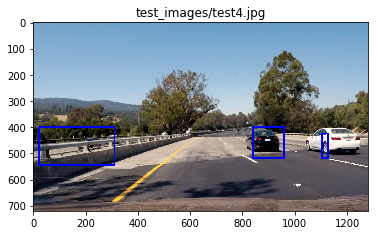

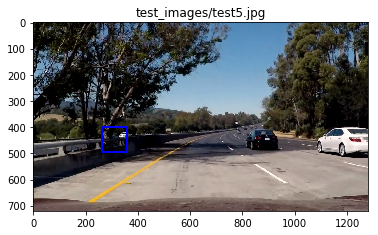

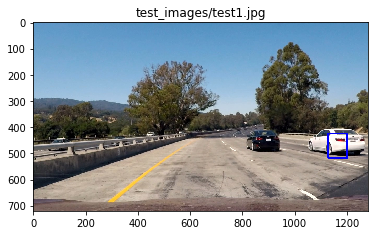

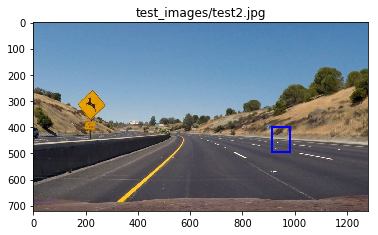

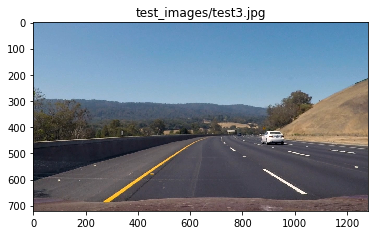

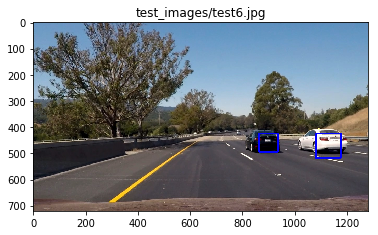

In [33]:
color_space_select(color_space='YUV')

# HLS

Feature vector length: 6108
156.19 Seconds to train SVC...
Test Accuracy of SVC =  0.989


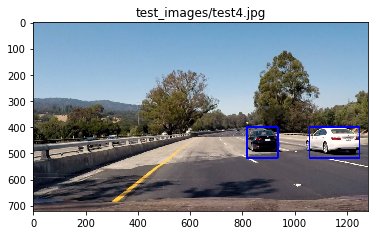

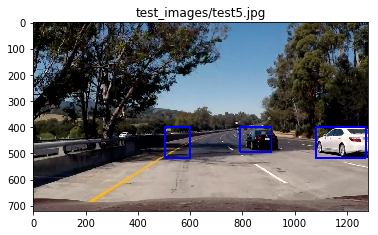

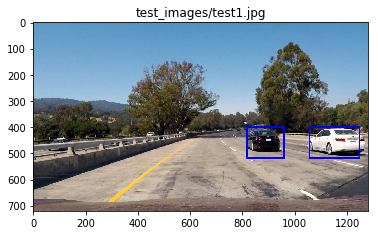

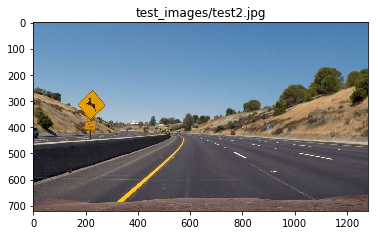

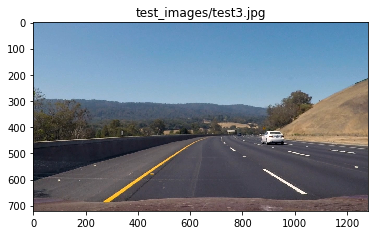

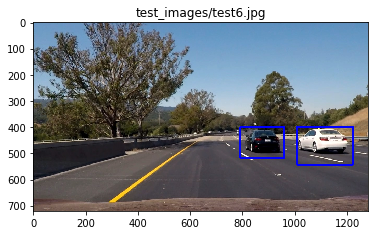

In [34]:
color_space_select(color_space='HLS')

# LUV

Feature vector length: 6108
180.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


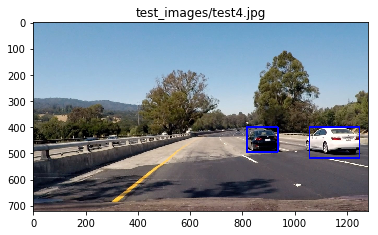

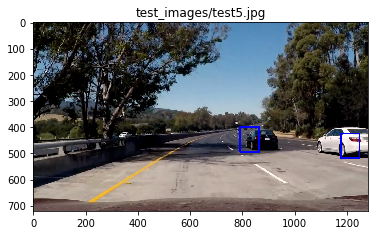

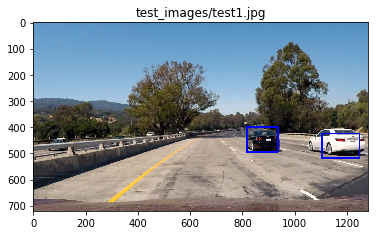

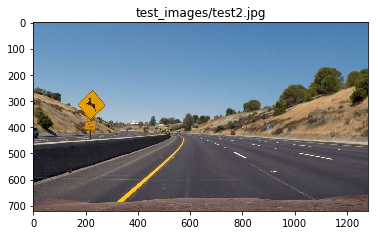

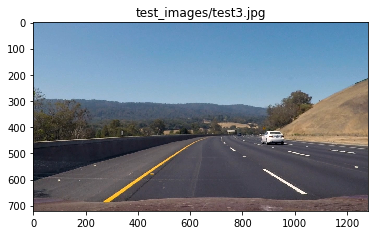

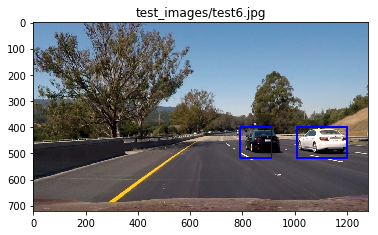

In [35]:
color_space_select(color_space='LUV')

# HSV

Feature vector length: 6108
148.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9887


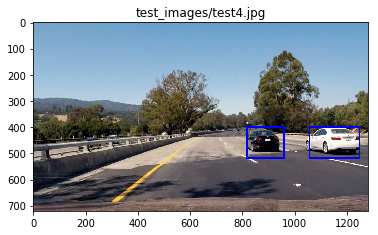

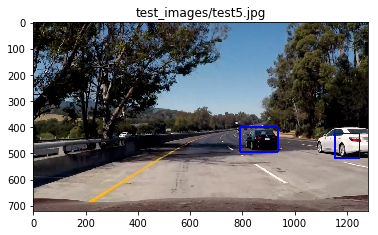

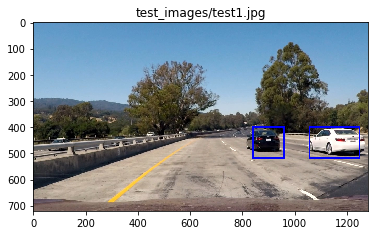

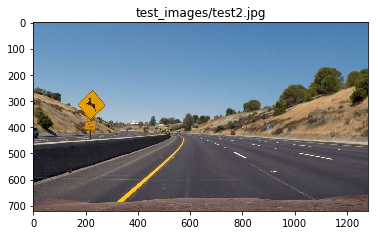

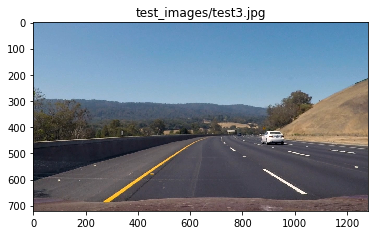

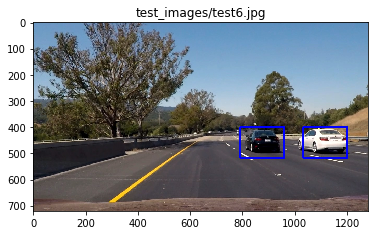

In [36]:
color_space_select(color_space='HSV')

# YCrCb

Feature vector length: 6108
171.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


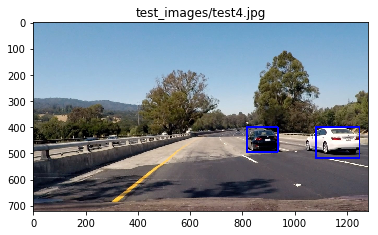

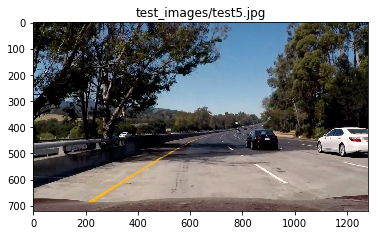

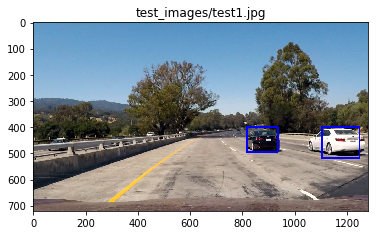

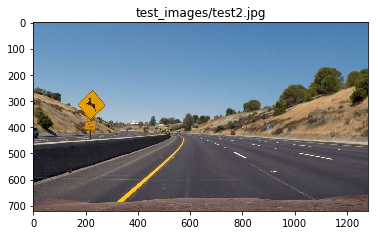

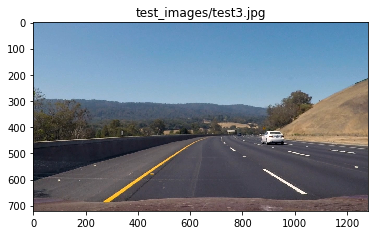

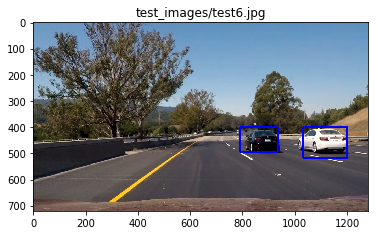

In [37]:
color_space_select(color_space='YCrCb')

# test video

In [301]:
input_video = 'test_video.mp4'
# input_video = 'challenge_video.mp4'
# clip = VideoFileClip(input_video).subclip(39,43)
clip = VideoFileClip(input_video)
output_clip = clip.fl_image(pipeline)
output_clip.write_videofile('output_' + input_video, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

